In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors, ensemble, svm, metrics
from imblearn.under_sampling import CondensedNearestNeighbour
import copy

### Составляем различные таблицы

In [2]:
dau = pd.read_csv('practice_dau_and.csv', sep='|')
pact = pd.read_csv('practice_pact_and.csv', sep='|')
print('Loaded')

Loaded


In [17]:
pay_players = pact[pact.transactions > 0].reset_index()
pay_players = pay_players.drop(['index'], axis='columns')
#print(pay_players)
pay_players.to_csv('pay_players_pact.csv', sep='|')
pay_players = pay_players.groupby(['id'], as_index=False).count()
pay_players = pay_players.drop(['actdate', 'regdate', 'clusters', 
                                'revenue', 'transactions', 'quest',
                                'm_quests', 'crystals', 'store_enters'], axis='columns')
print(pay_players)
pay_players.to_csv('pay_players.csv')

               id
0      0001c0d9c5
1      000249ee3b
2      0004bbc378
3      000bc5be57
4      00137c70eb
5      001501221a
6      001566c949
7      0016ec0270
8      001bdcf118
9      001dcb349d
10     001e86bb74
11     001f6f6bda
12     00217a789a
13     00240222ee
14     002adc591b
15     002d410bd3
16     002f2521f5
17     0030797a91
18     0030b81513
19     0032eb2d55
20     00332e58de
21     003544c4ea
22     003717dd8c
23     00371a21a9
24     00380b3464
25     003b4acbbd
26     003c981696
27     003d74cb8d
28     003e1afdab
29     003e67dd8a
...           ...
30391  ffb16a1c26
30392  ffb3c42867
30393  ffb5376eee
30394  ffb71a2641
30395  ffbbd7823a
30396  ffbd959b77
30397  ffbff6e3b0
30398  ffc1670161
30399  ffc286fc79
30400  ffc638b435
30401  ffc7cc6362
30402  ffca076aee
30403  ffd59fa03d
30404  ffd5a29fa9
30405  ffdc226141
30406  ffdd5e88b8
30407  ffdf621be9
30408  ffe0ac456f
30409  ffe5094796
30410  ffe5227876
30411  ffe8349510
30412  ffea788845
30413  ffeba687e9
30414  ffe

In [20]:
dau2 = pd.merge(pay_players, dau, on=['id'], how='left')

In [103]:
print(dau)
print(dau2)

In [22]:
dau2.to_csv('pay_players_dau.csv')

In [24]:
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')

In [26]:
print(dau_pact)
dau_pact.to_csv('pay_players_dau_pact.csv')

                id country  pgr     actdate     regdate  clusters  revenue  \
0       0001c0d9c5      RU    7  2017-01-28         NaN       NaN      NaN   
1       0001c0d9c5      RU   23  2017-01-30  2017-01-24      19.0     0.00   
2       0001c0d9c5      RU  219  2017-01-24  2017-01-24      13.0  4237.98   
3       0001c0d9c5      RU  164  2017-01-26  2017-01-24      18.0     0.00   
4       0001c0d9c5      RU  169  2017-01-25  2017-01-24      17.0  5922.96   
5       0001c0d9c5      RU   68  2017-01-29  2017-01-24      19.0  2118.99   
6       0001c0d9c5      RU    6  2017-03-01  2017-03-01      -2.0     0.00   
7       000249ee3b      US    2  2017-04-17         NaN       NaN      NaN   
8       000249ee3b      US   84  2017-04-13  2017-04-11       8.0     0.00   
9       000249ee3b      US   67  2017-04-16  2017-04-11       9.0     0.00   
10      000249ee3b      US  227  2017-04-11  2017-04-11       5.0     0.00   
11      000249ee3b      US   96  2017-04-12  2017-04-11       5.

In [65]:
dau2 = pd.read_csv('pay_players_dau.csv', parse_dates=True).drop('Unnamed: 0', axis='columns')

In [27]:
dau_pact = dau_pact.set_index('actdate', drop=False).sort_index(0)

### График, показывающий активность игрока

In [19]:
def show_player_pgr(player_id, days=31):
    player_table = pd.DataFrame({'id': [player_id]})
    res = pd.merge(player_table, dau_pact, on=['id'], how='left')
    #print(res)
    res = res.drop(['crystals', 'store_enters', 'm_quests', 'quest', 
                    'revenue', 'transactions', 'country', 'clusters'], axis='columns')
    res = res.groupby(['actdate'], as_index=False).sum()
    res = res.set_index('actdate')
    res = res.sort_index(0)
    res = res.reset_index()
    #print(res)
    first_day = res['actdate'][0]
    m_later_day = pd.date_range(first_day, periods=days, freq='D').date[-1]
    #print(first_day, str(m_later_day))
    new_sample_df = res.set_index('actdate').loc[first_day:str(m_later_day)]
    new_sample_df.plot()
    plt.show()

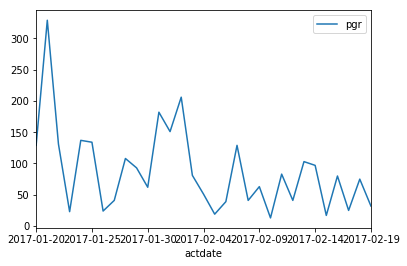

In [20]:
show_player_pgr('0004bbc378')

### Сводная таблица

In [96]:
dau_pact = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
dau_pact_table = dau_pact.drop(['clusters', 'revenue', 'quest', 
                          'm_quests', 'crystals', 'store_enters', 
                          'transactions', 'country'], axis='columns')

In [97]:
dau_pact_table['day_n'] = (pd.to_datetime(dau_pact_table['actdate']) - 
                           pd.to_datetime(dau_pact_table['regdate'])).dt.days
dau_pact_table = dau_pact_table[dau_pact_table.day_n < 31 + 14].reset_index()
dau_pact_table = dau_pact_table[pd.to_datetime(dau_pact_table.regdate) < pd.to_datetime('2017-04-15')].reset_index()
dau_pact_table = dau_pact_table.pivot_table(values='pgr', columns=['day_n'], index=['id'], aggfunc='sum')

In [67]:
print(dau_pact_table)

               0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0  \
id                                                                           
0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0     NaN   
000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN     NaN   
0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0    41.0   
000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0     NaN   
00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   191.0   
001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   230.0   
0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   165.0   
001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0     NaN   
001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0     NaN   
001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0    55.0   
001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86

In [5]:
dau_pact_table.to_csv('dau_pact_table.csv')

### Различные признаки

In [21]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 1) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
#dau_pact_table['result_intensity'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
#                                                  38, 39, 40, 41, 42, 43, 44]].replace('NaN', 0).mean(1)
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

### Регрессия:

In [30]:
#clf_features = ['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                 'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax',
#                 'w1_mean', 'w2_mean', 'w3_mean', 'w4_mean',
#                 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean']#,
#                'quest_w1_mean',
#              'quest_w2_mean',        'quest_w3_mean',        'quest_w4_mean',
#           'm_quests_w1_mean',     'm_quests_w2_mean',     'm_quests_w3_mean',
#           'm_quests_w4_mean',     'crystals_w1_mean',     'crystals_w2_mean',
#           'crystals_w3_mean',     'crystals_w4_mean', 'transactions_w1_mean',
#       'transactions_w2_mean', 'transactions_w3_mean', 'transactions_w4_mean']

dau_pact_table = dau_pact_table.fillna(0)
dau_pact_table.replace(np.inf, 0, inplace=True)
dau_pact_table.replace(-np.inf, 0, inplace=True)
for col in clf_features:
    dau_pact_table[col] = dau_pact_table[col].round(4)
#print(dau_pact_table)

train_input_clf = dau_pact_table[:16000].as_matrix(columns=clf_features)
train_output_clf = np.array(dau_pact_table['is_active'][:16000].tolist())

#cnn = CondensedNearestNeighbour(random_state=42) 
#train_input_clf, train_output_clf = cnn.fit_sample(train_input_clf, train_output_clf)

#fitted_clf = linear_model.SGDClassifier(loss='log', epsilon=0.01, n_iter=4).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

#fitted_clf = linear_model.SGDRegressor(epsilon=0.01).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf.predict(dau_pact_table.as_matrix(columns=clf_features)).round()

#fitted_clf_rfr = ensemble.RandomForestRegressor(n_estimators=30).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_rfr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()


fitted_clf_gbr = ensemble.GradientBoostingRegressor(subsample=0.7, loss='ls').fit(train_input_clf, train_output_clf)
dau_pact_table['predict_active'] = fitted_clf_gbr.predict(dau_pact_table.as_matrix(
                                                            columns=clf_features)).round()

#fitted_clf_etr = ensemble.ExtraTreesRegressor(n_estimators=20).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_etr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

#fitted_clf_svc = svm.SVC().fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_svc.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()


#fitted_clf_knr = neighbors.KNeighborsRegressor().fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_knr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                            'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

train_input_prd = dau_pact_table[:16000][dau_pact_table['is_active'] == 1].as_matrix(columns=clf_features)
train_output_prd = np.array(dau_pact_table[:16000][dau_pact_table['is_active'] == 1]['result_played'].tolist())

#train_input_prd, train_output_prd = cnn.fit_sample(train_input_prd, train_output_prd)
#fitted_prd = linear_model.SGDRegressor(epsilon=0.01).fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#fitted_prd_rfr = ensemble.RandomForestRegressor().fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_rfr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

fitted_prd_etr = ensemble.ExtraTreesRegressor(n_estimators=100).fit(train_input_prd, train_output_prd)
dau_pact_table['predict_days'] = fitted_prd_etr.predict(dau_pact_table.as_matrix(columns=clf_features))

#fitted_prd_bgr = ensemble.GradientBoostingRegressor(subsample=0.6, loss='ls').fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_bgr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#fitted_prd_knr = neighbors.KNeighborsRegressor(10).fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_knr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#train_input_cat = dau_pact_table[:16000].as_matrix(columns=clf_features)
#train_output_cat = np.array(dau_pact_table['result_category'][:16000].tolist())

#fitted_cat_prd_knr = neighbors.KNeighborsRegressor(10).fit(train_input_cat, train_output_cat)
#dau_pact_table['predict_category'] = fitted_cat_prd_knr.predict(dau_pact_table.as_matrix(columns=clf_features)).round()

dau_pact_table.set_index('id', inplace=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Попытки предсказаний, точность

In [31]:
#dau_pact_table['predict_intensity'] = (dau_pact_table['w1_mean'] * 0.2 
#                                       + dau_pact_table['w2_mean'] * 0.3 
#                                       + dau_pact_table['w3_mean'] * 0.5
#                                       + dau_pact_table['w4_mean'] * 1)
#dau_pact_table['intensity_acc'] = ((dau_pact_table['result_intensity'] - dau_pact_table['predict_intensity']).abs()
#                                   / (dau_pact_table['result_intensity']))
#dau_pact_table['predict_played'] = (dau_pact_table['w1_played'] * 0.2
#                                    + dau_pact_table['w2_played'] * 0.3
#                                    + dau_pact_table['w3_played'] * 0.5
#                                    + dau_pact_table['w4_played'] * 1).round()
#dau_pact_table['played_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_played']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['clf_acc'] = (dau_pact_table['is_active'] == dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e1'] = (dau_pact_table['is_active'] > dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e2'] = (dau_pact_table['is_active'] < dau_pact_table['predict_active']) * 1
#dau_pact_table['prd_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['prd_delta'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs())
dau_pact_table['overall_delta'] = ((dau_pact_table['result_played'] * dau_pact_table['is_active'] - dau_pact_table['predict_days'] * dau_pact_table['predict_active']).abs())
#dau_pact_table['category_delta'] = ((dau_pact_table['result_category'] - dau_pact_table['predict_category'])).abs()
#print(dau_pact_table)
#dau_pact_table = dau_pact_table.set_index('id')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Среднее отклонение классификатора активности: 0.105375096674
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.0641918020108
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.0411832946636
Среднее отклонение предсказателя дней: 2.66396440445
Среднее общее отклонение: 1.15288379737
[8942, 1618, 533, 118]
[2314, 1342, 344, 76]


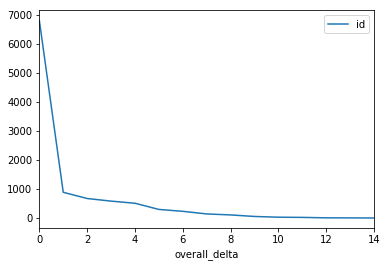

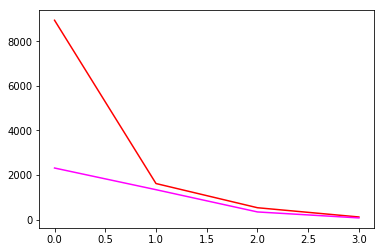

In [32]:
#num_inf = 0
#sum_infs = 0
#sum_v = 0
#num_v = 0
#nans = 0
prd_delta = dau_pact_table[16000:][dau_pact_table['is_active'] == 1]['prd_delta'].mean()
clf_delta = 1 - dau_pact_table['clf_acc'][16000:].mean()
clf_e1 = dau_pact_table['clf_e1'][16000:].mean()
clf_e2 = dau_pact_table['clf_e2'][16000:].mean()
overall_delta = dau_pact_table['overall_delta'][16000:].mean()
#category_delta = dau_pact_table['category_delta'][16000:].mean()
#for i in range(0, 26435):
#    #print(dau_pact_table['played_acc'][i])
#    if np.isnan(dau_pact_table['regr_acc'][i]):
#        nans += 1
#    elif not np.isfinite(dau_pact_table['regr_acc'][i]):
#        sum_infs += dau_pact_table['regr_predict_played'][i]
#        num_inf += 1
#    else:
#        sum_v += dau_pact_table['regr_acc'][i]
#        num_v += 1
#print("Среднее процентное отклонение (не inf):", sum_v / num_v * 100, '%')
#print("Среднее отклонение для acc=inf (дни): ", sum_infs / num_inf)
#print("Среднее отклонение (дни):", delta)
print('Среднее отклонение классификатора активности:', clf_delta)
print('Ошибка классификатора 1 рода (игрок на самом деле активен):', clf_e1)
print('Ошибка классификатора 2 рода (игрок на самом деле неактивен):', clf_e2)
print('Среднее отклонение предсказателя дней:', prd_delta)
print('Среднее общее отклонение:', overall_delta)
#print('Среднее отклонение категории:', category_delta)
overall_delta_round = dau_pact_table['overall_delta'][16000:].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
active_delta_round = dau_pact_table[16000:][dau_pact_table['is_active'] == 1.0]['overall_delta'].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
overall_delta_round.plot()
#print(overall_delta_round)
#print(active_delta_round)
categories_delta = [int(overall_delta_round[0:3].sum()), int(overall_delta_round[3:6].sum()), int(overall_delta_round[6:9].sum()), int(overall_delta_round[9:14].sum())]
active_categories_delta = [int(active_delta_round[0:3].sum()), int(active_delta_round[3:6].sum()), int(active_delta_round[6:9].sum()), int(active_delta_round[9:14].sum())]
print(categories_delta)
print(active_categories_delta)
plt.show()
plt.plot(categories_delta, color='red')
plt.plot(active_categories_delta, color='magenta')
plt.show()

In [98]:
dau_pact_features = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
features = ['pgr', 'clusters', 'quest', 'm_quests', 'transactions']
dau_pact_features['day_n'] = (pd.to_datetime(dau_pact_features['actdate']) - 
                           pd.to_datetime(dau_pact_features['regdate'])).dt.days
dau_pact_features = dau_pact_features[dau_pact_features.day_n < 31 + 14]
dau_pact_features = dau_pact_features[pd.to_datetime(dau_pact_features.regdate) < pd.to_datetime('2017-04-15')]
pay_players = pd.read_csv('pay_players.csv').drop('Unnamed: 0', axis='columns')
feature_table = pd.DataFrame(pay_players)
clf_features = []
#print(feature_table)
for feat in features:
    dau_pact_features_tmp = dau_pact_features.pivot_table(values=feat, columns=['day_n'], index=['id'], aggfunc='sum')
    dau_pact_features_tmp[feat+'_w1_mean'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w2_mean'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w3_mean'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w4_mean'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w1_max'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w2_max'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w3_max'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w4_max'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w1_meandmax'] = (dau_pact_features_tmp[feat+'_w1_mean'] / dau_pact_features_tmp[feat+'_w1_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w2_meandmax'] = (dau_pact_features_tmp[feat+'_w2_mean'] / dau_pact_features_tmp[feat+'_w2_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w3_meandmax'] = (dau_pact_features_tmp[feat+'_w3_mean'] / dau_pact_features_tmp[feat+'_w3_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w4_meandmax'] = (dau_pact_features_tmp[feat+'_w4_mean'] / dau_pact_features_tmp[feat+'_w4_max']).replace('NaN', 0)
    #for col in dau_pact_features_tmp.columns[:-4]:
    #    if col >= 3.0 and col <= 30.0:
    #        clf_features.append(feat+'_'+str(col))
    #    dau_pact_features_tmp.rename(columns={col: feat+'_'+str(col)}, inplace=True)
    dau_pact_features_tmp = dau_pact_features_tmp.reset_index()
    #print(dau_pact_features_tmp[feat+'_w1_mean'])
    
    #print(pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}))
    #print(feature_table)
    feature_table = pd.merge(feature_table, pd.DataFrame({'id': dau_pact_features_tmp['id'],
                                                          feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
                                                          feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
                                                          feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
                                                          feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean'],
                                                          feat+'_w1_max': dau_pact_features_tmp[feat+'_w1_max'],
                                                          feat+'_w2_max': dau_pact_features_tmp[feat+'_w2_max'],
                                                          feat+'_w3_max': dau_pact_features_tmp[feat+'_w3_max'],
                                                          feat+'_w4_max': dau_pact_features_tmp[feat+'_w4_max'],
                                                          feat+'_w1_meandmax': dau_pact_features_tmp[feat+'_w1_meandmax'],
                                                          feat+'_w2_meandmax': dau_pact_features_tmp[feat+'_w2_meandmax'],
                                                          feat+'_w3_meandmax': dau_pact_features_tmp[feat+'_w3_meandmax'],
                                                          feat+'_w4_meandmax': dau_pact_features_tmp[feat+'_w4_meandmax']}), 
                             how='inner', on=['id'])
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean']#,
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     #feat+'_w1_meandmax',
                     #feat+'_w2_meandmax',
                     #feat+'_w3_meandmax',
                     #feat+'_w4_meandmax']
    #feature_table = pd.merge(feature_table, dau_pact_features_tmp, on='id', how='inner')
    #print(feature_table)
    #print(pd.DataFrame([dau_pact_features_tmp['id'],
    #                                                  dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w4_mean']]))
    #dau_pact_features[feat+'_w1_mean'] = dau_pact_features_tmp[feat+'_w1_mean']
    #dau_pact_features[feat+'_w2_mean'] = dau_pact_features_tmp[feat+'_w2_mean']
    #dau_pact_features[feat+'_w3_mean'] = dau_pact_features_tmp[feat+'_w3_mean']
    #dau_pact_features[feat+'_w4_mean'] = dau_pact_features_tmp[feat+'_w4_mean']
    #print(dau_pact_features)

In [5]:
print(feature_table)
print(feature_table.columns)

               id  pgr_w1_max  pgr_w1_mean  pgr_w1_meandmax  pgr_w2_max  \
0      0001c0d9c5        68.0    45.500000         0.669118         NaN   
1      000249ee3b        67.0    67.000000         1.000000         NaN   
2      0004bbc378       137.0    89.500000         0.653285       206.0   
3      000bc5be57       224.0   113.000000         0.504464       236.0   
4      00137c70eb       694.0   307.500000         0.443084         NaN   
5      001566c949       230.0   130.000000         0.565217       189.0   
6      0016ec0270       165.0    66.166667         0.401010        26.0   
7      001bdcf118       162.0   119.000000         0.734568        77.0   
8      001dcb349d        96.0    70.333333         0.732639         NaN   
9      001e86bb74       142.0    87.200000         0.614085       176.0   
10     001f6f6bda       480.0   156.666667         0.326389       101.0   
11     00217a789a        26.0    17.000000         0.653846       252.0   
12     002adc591b        

In [99]:
feature_table.to_csv('feature_table.csv', index=False)

In [100]:
feature_table = pd.read_csv('feature_table.csv')
dau_pact_table = pd.merge(dau_pact_table.reset_index(), feature_table, on='id', how='inner')

In [101]:
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

In [102]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
#dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
#dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
#dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
#dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
#dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
#dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
#dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
#dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
#dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
#dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
#dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
#dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 0) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
clf_features += ['w1_played', 'w2_played', 'w3_played', 'w4_played']
dau_pact_table = dau_pact_table.set_index('id')

In [19]:
print(dau_pact_table.columns)

Index([                       0.0,                        1.0,
                              2.0,                        3.0,
                              4.0,                        5.0,
                              6.0,                        7.0,
                              8.0,                        9.0,
       ...
           'transactions_w4_mean', 'transactions_w4_meandmax',
                       'm_played',                'w1_played',
                      'w2_played',                'w3_played',
                      'w4_played',            'result_played',
                      'is_active',          'result_category'],
      dtype='object', length=125)


In [20]:
tmp = metrics.confusion_matrix(dau_pact_table[16000:]['is_active'], dau_pact_table[16000:]['predict_active'])

In [13]:
print(tmp)

[[6641  422]
 [ 678 2694]]


In [21]:
print(tmp)

[[6738  325]
 [ 720 2652]]


In [16]:
country_feature = (pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns').set_index('id')['country']).reset_index()
map_country = dict()
for i in range(len(country_feature['id'])):
    map_country[country_feature['id'][i]] = country_feature['country'][i]
country_array = []
id_array = []
for _id in map_country:
    id_array.append(_id)
    country_array.append(map_country[_id])
country_feature = pd.get_dummies(pd.DataFrame({'id': id_array, 'country': country_array}).set_index('id')['country']).reset_index()

In [50]:
print(country_feature)
print(country_feature.columns)

               id  --  AE  AM  AR  AT  AU  AW  AZ  BA ...  TT  TW  TZ  UA  US  \
0      8657fd9864   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
1      384332f747   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
2      22139ab537   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   
3      6235e3e291   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
4      2222236ac7   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
5      a3edc8f3c3   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
6      5aa4215ec4   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
7      e990bd8e89   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
8      3da00c9d73   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
9      5bf13afc59   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
10     4b497cbb05   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
11     11420820a9   0   0   

In [51]:
#print(dau_pact_table.reset_index())
dau_pact_table = pd.merge(dau_pact_table.reset_index(), country_feature, on='id', how='left').set_index('id')
clf_features += list(country_feature.columns)[1:]

In [2]:
pact = pd.read_csv('practice_pact_and.csv', sep='|')
players_regdates = pd.DataFrame({'id': pact[pact.transactions > 0]['id'], 'regdate': pact[pact.transactions > 0]['regdate']}).drop_duplicates().reset_index().drop('index', axis='columns')
del pact
sessions = pd.read_csv('practice_sessions_and.csv', sep='|')
pay_players_sessions = pd.merge(players_regdates, sessions, on='id', how='left').drop(['session_number'], axis='columns')
pay_players_sessions['day_n'] = (pd.to_datetime(pay_players_sessions['actdate']) - 
                           pd.to_datetime(pay_players_sessions['regdate'])).dt.days
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n < 31 + 14]
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n >= 0]
pay_players_sessions = pay_players_sessions[pd.to_datetime(pay_players_sessions.regdate) < pd.to_datetime('2017-04-15')]
pay_players_sessions.to_csv('pay_players_sessions.csv', index=False)

In [68]:
pay_players_sessions = pd.read_csv('pay_players_sessions.csv')
sum_len_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='sum')
n_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='count')

In [106]:
n_sess['sess_w1_mean'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
n_sess['sess_w2_mean'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
n_sess['sess_w3_mean'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
n_sess['sess_w4_mean'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
n_sess['sess_w1_max'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
n_sess['sess_w2_max'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
n_sess['sess_w3_max'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
n_sess['sess_w4_max'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
n_sess['sess_w1_meandmax'] = n_sess['sess_w1_mean'] / n_sess['sess_w1_max']
n_sess['sess_w2_meandmax'] = n_sess['sess_w2_mean'] / n_sess['sess_w2_max']
n_sess['sess_w3_meandmax'] = n_sess['sess_w3_mean'] / n_sess['sess_w3_max']
n_sess['sess_w4_meandmax'] = n_sess['sess_w4_mean'] / n_sess['sess_w4_max']
clf_features += ['sess_w1_mean',
                 'sess_w2_mean',
                 'sess_w3_mean',
                 'sess_w4_mean']#,
                 #'sess_w1_max',
                 #'sess_w2_max',
                 #'sess_w3_max',
                 #'sess_w4_max',
                 #'sess_w1_meandmax',
                 #'sess_w2_meandmax',
                 #'sess_w3_meandmax',
                 #'sess_w4_meandmax']
n_sess.reset_index(inplace=True)
sum_len_sess['lensess_w1_mean'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w2_mean'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w3_mean'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w4_mean'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w1_max'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w2_max'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w3_max'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w4_max'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w1_meandmax'] = sum_len_sess['lensess_w1_mean'] / sum_len_sess['lensess_w1_max']
sum_len_sess['lensess_w2_meandmax'] = sum_len_sess['lensess_w2_mean'] / sum_len_sess['lensess_w2_max']
sum_len_sess['lensess_w3_meandmax'] = sum_len_sess['lensess_w3_mean'] / sum_len_sess['lensess_w3_max']
sum_len_sess['lensess_w4_meandmax'] = sum_len_sess['lensess_w4_mean'] / sum_len_sess['lensess_w4_max']
sum_len_sess.reset_index(inplace=True)
sess_features = pd.DataFrame({'id': n_sess['id'],
                              'sess_w1_mean': n_sess['sess_w1_mean'],
                              'sess_w2_mean': n_sess['sess_w2_mean'],
                              'sess_w3_mean': n_sess['sess_w3_mean'],
                              'sess_w4_mean': n_sess['sess_w4_mean'],
                              #'sess_w1_max': n_sess['sess_w1_max'],
                              #'sess_w2_max': n_sess['sess_w2_max'],
                              #'sess_w3_max': n_sess['sess_w3_max'],
                              #'sess_w4_max': n_sess['sess_w4_max'],
                              'sess_w1_meandmax': n_sess['sess_w1_meandmax'],
                              'sess_w2_meandmax': n_sess['sess_w2_meandmax'],
                              'sess_w3_meandmax': n_sess['sess_w3_meandmax'],
                              'sess_w4_meandmax': n_sess['sess_w4_meandmax']})
sess_features = pd.merge(sess_features, pd.DataFrame({'id': sum_len_sess['id'],
                              #'lensess_w1_mean': sum_len_sess['lensess_w1_mean'],
                              #'lensess_w2_mean': sum_len_sess['lensess_w2_mean'],
                              #'lensess_w3_mean': sum_len_sess['lensess_w3_mean'],
                              #'lensess_w4_mean': sum_len_sess['lensess_w4_mean'],
                              #'lensess_w1_max': sum_len_sess['lensess_w1_max'],
                              #'lensess_w2_max': sum_len_sess['lensess_w2_max'],
                              #'lensess_w3_max': sum_len_sess['lensess_w3_max'],
                              #'lensess_w4_max': sum_len_sess['lensess_w4_max'],
                              'lensess_w1_meandmax': sum_len_sess['lensess_w1_meandmax'],
                              'lensess_w2_meandmax': sum_len_sess['lensess_w2_meandmax'],
                              'lensess_w3_meandmax': sum_len_sess['lensess_w3_meandmax'],
                              'lensess_w4_meandmax': sum_len_sess['lensess_w4_meandmax']}),
                        how='inner', on='id')
clf_features += [#'lensess_w1_mean',
                 #'lensess_w2_mean',
                 #'lensess_w3_mean',
                 #'lensess_w4_mean',
                 #'lensess_w1_max',
                 #'lensess_w2_max',
                 #'lensess_w3_max',
                 #'lensess_w4_max',
                 'lensess_w1_meandmax',
                 'lensess_w2_meandmax',
                 'lensess_w3_meandmax',
                 'lensess_w4_meandmax']

In [107]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), sess_features, on='id', how='inner')

# Составляем сводную таблицу (dau_pact_table)

Основа сводной таблицы:

In [13]:
dau_pact = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
dau_pact_table = dau_pact.drop(['clusters', 'revenue', 'quest', 
                          'm_quests', 'crystals', 'store_enters', 
                          'transactions', 'country'], axis='columns')
dau_pact_table['day_n'] = (pd.to_datetime(dau_pact_table['actdate']) - 
                           pd.to_datetime(dau_pact_table['regdate'])).dt.days
dau_pact_table = dau_pact_table[dau_pact_table.day_n < 31 + 14].reset_index()
dau_pact_table = dau_pact_table[pd.to_datetime(dau_pact_table.regdate) < pd.to_datetime('2017-04-15')].reset_index()
dau_pact_table = dau_pact_table.pivot_table(values='pgr', columns=['day_n'], index=['id'], aggfunc='sum')

Составляем таблицу фич:

In [14]:
dau_pact_features = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
features = ['pgr', 'clusters', 'quest', 'm_quests', 'transactions', 'revenue']
dau_pact_features['day_n'] = (pd.to_datetime(dau_pact_features['actdate']) - 
                           pd.to_datetime(dau_pact_features['regdate'])).dt.days
dau_pact_features = dau_pact_features[dau_pact_features.day_n < 31 + 14]
dau_pact_features = dau_pact_features[pd.to_datetime(dau_pact_features.regdate) < pd.to_datetime('2017-04-15')]
pay_players = pd.read_csv('pay_players.csv').drop('Unnamed: 0', axis='columns')
feature_table = pd.DataFrame(pay_players)
clf_features = []
#print(feature_table)
for feat in features:
    dau_pact_features_tmp = dau_pact_features.pivot_table(values=feat, columns=['day_n'], index=['id'], aggfunc='sum')
    dau_pact_features_tmp[feat+'_w1_mean'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w2_mean'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w3_mean'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w4_mean'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w1_max'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w2_max'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w3_max'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w4_max'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w1_meandmax'] = (dau_pact_features_tmp[feat+'_w1_mean'] / dau_pact_features_tmp[feat+'_w1_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w2_meandmax'] = (dau_pact_features_tmp[feat+'_w2_mean'] / dau_pact_features_tmp[feat+'_w2_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w3_meandmax'] = (dau_pact_features_tmp[feat+'_w3_mean'] / dau_pact_features_tmp[feat+'_w3_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w4_meandmax'] = (dau_pact_features_tmp[feat+'_w4_mean'] / dau_pact_features_tmp[feat+'_w4_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w1_av_deviat'] = (dau_pact_features_tmp[feat+'_w1_mean'] - dau_pact_features_tmp[3.0]).abs()
    for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
        dau_pact_features_tmp[feat+'_w1_av_deviat'] += (dau_pact_features_tmp[feat+'_w1_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w1_av_deviat'] /= 7
    dau_pact_features_tmp[feat+'_w2_av_deviat'] = (dau_pact_features_tmp[feat+'_w2_mean'] - dau_pact_features_tmp[10.0]).abs()
    for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
        dau_pact_features_tmp[feat+'_w2_av_deviat'] += (dau_pact_features_tmp[feat+'_w2_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w2_av_deviat'] /= 7
    dau_pact_features_tmp[feat+'_w3_av_deviat'] = (dau_pact_features_tmp[feat+'_w3_mean'] - dau_pact_features_tmp[17.0]).abs()
    for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
        dau_pact_features_tmp[feat+'_w3_av_deviat'] += (dau_pact_features_tmp[feat+'_w3_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w3_av_deviat'] /= 7
    dau_pact_features_tmp[feat+'_w4_av_deviat'] = (dau_pact_features_tmp[feat+'_w4_mean'] - dau_pact_features_tmp[24.0]).abs()
    for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
        dau_pact_features_tmp[feat+'_w4_av_deviat'] += (dau_pact_features_tmp[feat+'_w4_mean'] - dau_pact_features_tmp[i]).abs()
    dau_pact_features_tmp[feat+'_w4_av_deviat'] /= 7
    #for col in dau_pact_features_tmp.columns[:-4]:
    #    if col >= 3.0 and col <= 30.0:
    #        clf_features.append(feat+'_'+str(col))
    #    dau_pact_features_tmp.rename(columns={col: feat+'_'+str(col)}, inplace=True)
    dau_pact_features_tmp = dau_pact_features_tmp.reset_index()
    #print(dau_pact_features_tmp[feat+'_w1_mean'])
    
    #print(pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}))
    #print(feature_table)
    feature_table = pd.merge(feature_table, pd.DataFrame({'id': dau_pact_features_tmp['id'],
                                                          feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
                                                          feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
                                                          feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
                                                          feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean'],
                                                          #feat+'_w1_max': dau_pact_features_tmp[feat+'_w1_max'],
                                                          #feat+'_w2_max': dau_pact_features_tmp[feat+'_w2_max'],
                                                          #feat+'_w3_max': dau_pact_features_tmp[feat+'_w3_max'],
                                                          #feat+'_w4_max': dau_pact_features_tmp[feat+'_w4_max'],
                                                          feat+'_w1_meandmax': dau_pact_features_tmp[feat+'_w1_meandmax'],
                                                          feat+'_w2_meandmax': dau_pact_features_tmp[feat+'_w2_meandmax'],
                                                          feat+'_w3_meandmax': dau_pact_features_tmp[feat+'_w3_meandmax'],
                                                          feat+'_w4_meandmax': dau_pact_features_tmp[feat+'_w4_meandmax'],
                                                          feat+'_w1_av_deviat': dau_pact_features_tmp[feat+'_w1_av_deviat'],
                                                          feat+'_w2_av_deviat': dau_pact_features_tmp[feat+'_w2_av_deviat'],
                                                          feat+'_w3_av_deviat': dau_pact_features_tmp[feat+'_w3_av_deviat'],
                                                          feat+'_w4_av_deviat': dau_pact_features_tmp[feat+'_w4_av_deviat']}), 
                             how='inner', on=['id'])
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean',
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     feat+'_w1_meandmax',
                     feat+'_w2_meandmax',
                     feat+'_w3_meandmax',
                     feat+'_w4_meandmax',
                     feat+'_w1_av_deviat',
                     feat+'_w2_av_deviat',
                     feat+'_w3_av_deviat',
                     feat+'_w4_av_deviat']
    #feature_table = pd.merge(feature_table, dau_pact_features_tmp, on='id', how='inner')
    #print(feature_table)
    #print(pd.DataFrame([dau_pact_features_tmp['id'],
    #                                                  dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w4_mean']]))
    #print(dau_pact_features)

In [15]:
#print(feature_table)
#print(feature_table.columns)
feature_table.to_csv('feature_table.csv', index=False)

In [16]:
feature_table = pd.read_csv('feature_table.csv')
dau_pact_table = pd.merge(dau_pact_table.reset_index(), feature_table, on='id', how='inner')

Дополнительные фичи и столбцы:

In [17]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
#dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
#dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
#dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
#dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
#dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
#dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
#dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
#dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
#dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
#dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
#dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
#dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 0) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
clf_features += ['w1_played', 'w2_played', 'w3_played', 'w4_played']
dau_pact_table = dau_pact_table.set_index('id')

Составляем сводные таблицы на основе данных 3-й таблицы:

In [18]:
pay_players_sessions = pd.read_csv('pay_players_sessions.csv')
sum_len_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='sum')
n_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='count')

In [19]:
n_sess['sess_w1_mean'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
n_sess['sess_w2_mean'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
n_sess['sess_w3_mean'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
n_sess['sess_w4_mean'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
n_sess['sess_w1_max'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
n_sess['sess_w2_max'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
n_sess['sess_w3_max'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
n_sess['sess_w4_max'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
n_sess['sess_w1_meandmax'] = n_sess['sess_w1_mean'] / n_sess['sess_w1_max']
n_sess['sess_w2_meandmax'] = n_sess['sess_w2_mean'] / n_sess['sess_w2_max']
n_sess['sess_w3_meandmax'] = n_sess['sess_w3_mean'] / n_sess['sess_w3_max']
n_sess['sess_w4_meandmax'] = n_sess['sess_w4_mean'] / n_sess['sess_w4_max']
n_sess['sess_w1_av_deviat'] = (n_sess['sess_w1_mean'] - n_sess[3.0]).abs()
for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    n_sess['sess_w1_av_deviat'] += (n_sess['sess_w1_mean'] - n_sess[i]).abs()
n_sess['sess_w1_av_deviat'] /= 7
n_sess['sess_w2_av_deviat'] = (n_sess['sess_w2_mean'] - n_sess[10.0]).abs()
for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
    n_sess['sess_w2_av_deviat'] += (n_sess['sess_w2_mean'] - n_sess[i]).abs()
n_sess['sess_w2_av_deviat'] /= 7
n_sess['sess_w3_av_deviat'] = (n_sess['sess_w3_mean'] - n_sess[17.0]).abs()
for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
    n_sess['sess_w3_av_deviat'] += (n_sess['sess_w3_mean'] - n_sess[i]).abs()
n_sess['sess_w3_av_deviat'] /= 7
n_sess['sess_w4_av_deviat'] = (n_sess['sess_w4_mean'] - n_sess[24.0]).abs()
for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
    n_sess['sess_w4_av_deviat'] += (n_sess['sess_w4_mean'] - n_sess[i]).abs()
n_sess['sess_w4_av_deviat'] /= 7
clf_features += ['sess_w1_mean',
                 'sess_w2_mean',
                 'sess_w3_mean',
                 'sess_w4_mean',
                 #'sess_w1_max',
                 #'sess_w2_max',
                 #'sess_w3_max',
                 #'sess_w4_max',
                 'sess_w1_meandmax',
                 'sess_w2_meandmax',
                 'sess_w3_meandmax',
                 'sess_w4_meandmax',
                 'sess_w1_av_deviat',
                 'sess_w2_av_deviat',
                 'sess_w3_av_deviat',
                 'sess_w4_av_deviat']
n_sess.reset_index(inplace=True)
sum_len_sess['lensess_w1_mean'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w2_mean'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w3_mean'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w4_mean'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w1_max'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w2_max'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w3_max'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w4_max'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w1_meandmax'] = sum_len_sess['lensess_w1_mean'] / sum_len_sess['lensess_w1_max']
sum_len_sess['lensess_w2_meandmax'] = sum_len_sess['lensess_w2_mean'] / sum_len_sess['lensess_w2_max']
sum_len_sess['lensess_w3_meandmax'] = sum_len_sess['lensess_w3_mean'] / sum_len_sess['lensess_w3_max']
sum_len_sess['lensess_w4_meandmax'] = sum_len_sess['lensess_w4_mean'] / sum_len_sess['lensess_w4_max']
sum_len_sess['lensess_w1_av_deviat'] = (sum_len_sess['lensess_w1_mean'] - sum_len_sess[3.0]).abs()
for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    sum_len_sess['lensess_w1_av_deviat'] += (sum_len_sess['lensess_w1_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w1_av_deviat'] /= 7
sum_len_sess['lensess_w2_av_deviat'] = (sum_len_sess['lensess_w2_mean'] - sum_len_sess[10.0]).abs()
for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
    sum_len_sess['lensess_w2_av_deviat'] += (sum_len_sess['lensess_w2_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w2_av_deviat'] /= 7
sum_len_sess['lensess_w3_av_deviat'] = (sum_len_sess['lensess_w3_mean'] - sum_len_sess[17.0]).abs()
for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
    sum_len_sess['lensess_w3_av_deviat'] += (sum_len_sess['lensess_w3_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w3_av_deviat'] /= 7
sum_len_sess['lensess_w4_av_deviat'] = (sum_len_sess['lensess_w4_mean'] - sum_len_sess[24.0]).abs()
for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
    sum_len_sess['lensess_w4_av_deviat'] += (sum_len_sess['lensess_w4_mean'] - sum_len_sess[i]).abs()
sum_len_sess['lensess_w4_av_deviat'] /= 7
sum_len_sess.reset_index(inplace=True)
sess_features = pd.DataFrame({'id': n_sess['id'],
                              'sess_w1_mean': n_sess['sess_w1_mean'],
                              'sess_w2_mean': n_sess['sess_w2_mean'],
                              'sess_w3_mean': n_sess['sess_w3_mean'],
                              'sess_w4_mean': n_sess['sess_w4_mean'],
                              #'sess_w1_max': n_sess['sess_w1_max'],
                              #'sess_w2_max': n_sess['sess_w2_max'],
                              #'sess_w3_max': n_sess['sess_w3_max'],
                              #'sess_w4_max': n_sess['sess_w4_max'],
                              'sess_w1_meandmax': n_sess['sess_w1_meandmax'],
                              'sess_w2_meandmax': n_sess['sess_w2_meandmax'],
                              'sess_w3_meandmax': n_sess['sess_w3_meandmax'],
                              'sess_w4_meandmax': n_sess['sess_w4_meandmax'],
                              'sess_w1_av_deviat': n_sess['sess_w1_av_deviat'],
                              'sess_w2_av_deviat': n_sess['sess_w2_av_deviat'],
                              'sess_w3_av_deviat': n_sess['sess_w3_av_deviat'],
                              'sess_w4_av_deviat': n_sess['sess_w4_av_deviat']})
sess_features = pd.merge(sess_features, pd.DataFrame({'id': sum_len_sess['id'],
                              'lensess_w1_mean': sum_len_sess['lensess_w1_mean'],
                              'lensess_w2_mean': sum_len_sess['lensess_w2_mean'],
                              'lensess_w3_mean': sum_len_sess['lensess_w3_mean'],
                              'lensess_w4_mean': sum_len_sess['lensess_w4_mean'],
                              #'lensess_w1_max': sum_len_sess['lensess_w1_max'],
                              #'lensess_w2_max': sum_len_sess['lensess_w2_max'],
                              #'lensess_w3_max': sum_len_sess['lensess_w3_max'],
                              #'lensess_w4_max': sum_len_sess['lensess_w4_max'],
                              'lensess_w1_meandmax': sum_len_sess['lensess_w1_meandmax'],
                              'lensess_w2_meandmax': sum_len_sess['lensess_w2_meandmax'],
                              'lensess_w3_meandmax': sum_len_sess['lensess_w3_meandmax'],
                              'lensess_w4_meandmax': sum_len_sess['lensess_w4_meandmax'],
                              'lensess_w1_av_deviat': sum_len_sess['lensess_w1_av_deviat'],
                              'lensess_w2_av_deviat': sum_len_sess['lensess_w2_av_deviat'],
                              'lensess_w3_av_deviat': sum_len_sess['lensess_w3_av_deviat'],
                              'lensess_w4_av_deviat': sum_len_sess['lensess_w4_av_deviat']}),
                        how='inner', on='id')
clf_features += ['lensess_w1_mean',
                 'lensess_w2_mean',
                 'lensess_w3_mean',
                 'lensess_w4_mean',
                 #'lensess_w1_max',
                 #'lensess_w2_max',
                 #'lensess_w3_max',
                 #'lensess_w4_max',
                 'lensess_w1_meandmax',
                 'lensess_w2_meandmax',
                 'lensess_w3_meandmax',
                 'lensess_w4_meandmax',
                 'lensess_w1_av_deviat',
                 'lensess_w2_av_deviat',
                 'lensess_w3_av_deviat',
                 'lensess_w4_av_deviat']

In [20]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), sess_features, on='id', how='inner')

In [21]:
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

In [11]:
print(clf_features)

['pgr_w1_mean', 'pgr_w2_mean', 'pgr_w3_mean', 'pgr_w4_mean', 'pgr_w1_meandmax', 'pgr_w2_meandmax', 'pgr_w3_meandmax', 'pgr_w4_meandmax', 'pgr_w1_av_deviat', 'pgr_w2_av_deviat', 'pgr_w3_av_deviat', 'pgr_w4_av_deviat', 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean', 'clusters_w1_meandmax', 'clusters_w2_meandmax', 'clusters_w3_meandmax', 'clusters_w4_meandmax', 'clusters_w1_av_deviat', 'clusters_w2_av_deviat', 'clusters_w3_av_deviat', 'clusters_w4_av_deviat', 'quest_w1_mean', 'quest_w2_mean', 'quest_w3_mean', 'quest_w4_mean', 'quest_w1_meandmax', 'quest_w2_meandmax', 'quest_w3_meandmax', 'quest_w4_meandmax', 'quest_w1_av_deviat', 'quest_w2_av_deviat', 'quest_w3_av_deviat', 'quest_w4_av_deviat', 'm_quests_w1_mean', 'm_quests_w2_mean', 'm_quests_w3_mean', 'm_quests_w4_mean', 'm_quests_w1_meandmax', 'm_quests_w2_meandmax', 'm_quests_w3_meandmax', 'm_quests_w4_meandmax', 'm_quests_w1_av_deviat', 'm_quests_w2_av_deviat', 'm_quests_w3_av_deviat', 'm_quests_w4_av_

#### Регрессия:

In [22]:
dau_pact_table = dau_pact_table.fillna(0)
dau_pact_table.replace(np.inf, 0, inplace=True)
dau_pact_table.replace(-np.inf, 0, inplace=True)
for col in clf_features:
    dau_pact_table[col] = dau_pact_table[col].round(4)

train_input_clf = dau_pact_table[:16000].as_matrix(columns=clf_features)
train_output_clf = np.array(dau_pact_table['is_active'][:16000].tolist())

fitted_clf_gbr = ensemble.GradientBoostingRegressor(subsample=0.7, loss='ls').fit(train_input_clf, train_output_clf)
dau_pact_table['predict_active'] = fitted_clf_gbr.predict(dau_pact_table.as_matrix(
                                                            columns=clf_features)).round()
train_input_prd = dau_pact_table[:16000][dau_pact_table['is_active'] == 1].as_matrix(columns=clf_features)
train_output_prd = np.array(dau_pact_table[:16000][dau_pact_table['is_active'] == 1]['result_played'].tolist())

fitted_prd_etr = ensemble.ExtraTreesRegressor(n_estimators=100).fit(train_input_prd, train_output_prd)
dau_pact_table['predict_days'] = fitted_prd_etr.predict(dau_pact_table.as_matrix(columns=clf_features))

dau_pact_table.set_index('id', inplace=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [23]:
dau_pact_table['clf_acc'] = (dau_pact_table['is_active'] == dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e1'] = (dau_pact_table['is_active'] > dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e2'] = (dau_pact_table['is_active'] < dau_pact_table['predict_active']) * 1
dau_pact_table['prd_delta'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs())
dau_pact_table['overall_delta'] = ((dau_pact_table['result_played'] * dau_pact_table['is_active'] - dau_pact_table['predict_days'] * dau_pact_table['predict_active']).abs())

#### Результаты:

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Среднее отклонение классификатора активности: 0.105375096674
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.0634184068059
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.0419566898685
Среднее отклонение предсказателя дней: 2.65950510146
Среднее общее отклонение: 1.14624226605
[8962, 1642, 516, 122]
[2332, 1354, 343, 81]


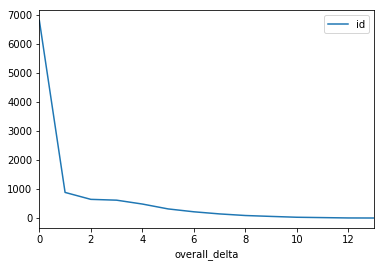

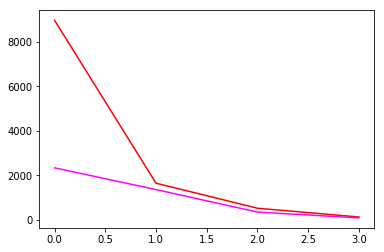

In [24]:
prd_delta = dau_pact_table[16000:][dau_pact_table['is_active'] == 1]['prd_delta'].mean()
clf_delta = 1 - dau_pact_table['clf_acc'][16000:].mean()
clf_e1 = dau_pact_table['clf_e1'][16000:].mean()
clf_e2 = dau_pact_table['clf_e2'][16000:].mean()
overall_delta = dau_pact_table['overall_delta'][16000:].mean()
print('Среднее отклонение классификатора активности:', clf_delta)
print('Ошибка классификатора 1 рода (игрок на самом деле активен):', clf_e1)
print('Ошибка классификатора 2 рода (игрок на самом деле неактивен):', clf_e2)
print('Среднее отклонение предсказателя дней:', prd_delta)
print('Среднее общее отклонение:', overall_delta)
overall_delta_round = dau_pact_table['overall_delta'][16000:].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
active_delta_round = dau_pact_table[16000:][dau_pact_table['is_active'] == 1.0]['overall_delta'].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
overall_delta_round.plot()
categories_delta = [int(overall_delta_round[0:3].sum()), int(overall_delta_round[3:6].sum()), int(overall_delta_round[6:9].sum()), int(overall_delta_round[9:14].sum())]
active_categories_delta = [int(active_delta_round[0:3].sum()), int(active_delta_round[3:6].sum()), int(active_delta_round[6:9].sum()), int(active_delta_round[9:14].sum())]
print(categories_delta)
print(active_categories_delta)
plt.show()
plt.plot(categories_delta, color='red')
plt.plot(active_categories_delta, color='magenta')
plt.show()

In [25]:
w_features = copy.copy(clf_features)
for i in range(len(clf_features)):
    w_features[i] = (fitted_clf_gbr.feature_importances_[i], clf_features[i])
w_features = sorted(w_features)
for i in range(len(w_features) - 1, -1, -1):
    print(w_features[i])

(0.1344930147207985, 'w4_played')
(0.069179616374630409, 'pgr_w4_mean')
(0.042347292900175838, 'm_quests_w4_meandmax')
(0.034870632357340461, 'sess_w4_mean')
(0.030568797938306837, 'sess_w4_meandmax')
(0.027200275997692785, 'clusters_w1_mean')
(0.027118954748276285, 'sess_w3_mean')
(0.022038523981301076, 'm_quests_w4_mean')
(0.021496546165891015, 'quest_w1_meandmax')
(0.021411454675012757, 'lensess_w3_meandmax')
(0.021207487728074549, 'clusters_w3_mean')
(0.02104546528707317, 'sess_w1_meandmax')
(0.019614052932455082, 'lensess_w4_meandmax')
(0.017575094674434417, 'lensess_w4_mean')
(0.017274074265720474, 'revenue_w1_mean')
(0.01579188977700418, 'clusters_w1_meandmax')
(0.014436311510505302, 'quest_w4_meandmax')
(0.014147759992950305, 'quest_w3_meandmax')
(0.013824117038375628, 'quest_w3_mean')
(0.013794475525507008, 'revenue_w2_mean')
(0.013258514657674515, 'clusters_w2_mean')
(0.013082925435326846, 'lensess_w1_meandmax')
(0.013047868938877848, 'pgr_w1_meandmax')
(0.012882107638061725,